In [3]:
import pandas as pd

df = pd.read_csv("behaviour_simulation_train.csv")

# print(df.shape)
df.shape #(300000, 7)
df.head()

# print(df.head())

df.info()

df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                300000 non-null  int64 
 1   date              300000 non-null  object
 2   likes             300000 non-null  int64 
 3   content           300000 non-null  object
 4   username          300000 non-null  object
 5   media             300000 non-null  object
 6   inferred company  300000 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.0+ MB


id                  0
date                0
likes               0
content             0
username            0
media               0
inferred company    0
dtype: int64

In [4]:
# Light Preprocessing
df.dropna(subset=['content', 'username', 'inferred company', 'likes'], inplace=True) #1. Remove rows with missing critical data

#inplace=True means it modifies the original DataFrame directly (no need to assign back to df)

df.fillna({'media':'no_media'}, inplace=True) #2. Fill missing media field with a placeholder

#Replaces all NaN values in the media column with the string 'no_media'.
# Makes the column consistent and easier to work with (no more null checks).
# Helps in creating features like has_media for modeling or filtering.


df['has_media'] = df['media'].apply(lambda x: x != 'no_media').astype(int)
#Adds a new boolean column (True or False) indicating whether a row includes media.

df['content'] = df['content'].astype(str).str.strip().str.lower()

#.astype(str): Converts all values to string type (" ") (handles any non-text data)
# Similar posts with different cases are identified
# Case-insensitive searching


df['datetime'] = pd.to_datetime(df['date'], errors='coerce')
# Converts the 'date' column to proper datetime format
# errors='coerce': Invalid dates become NaT (Not a Time) instead of raising errors
#strings become proper datetime obejcts , easy to analyze, filter, order and extract features

c:\Users\Tushar\Documents\CSAIC\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


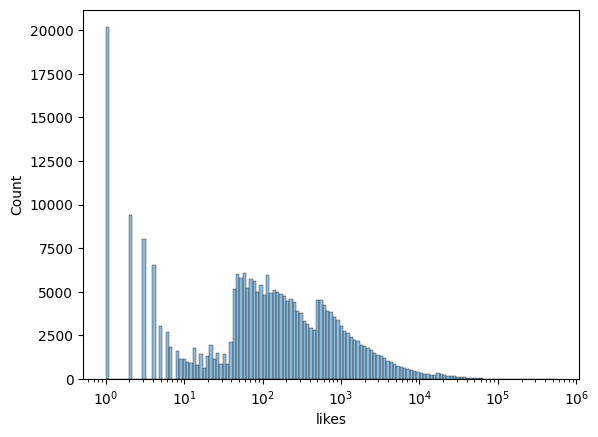

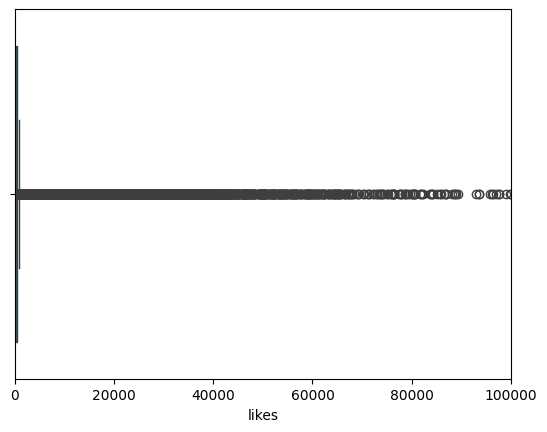

In [5]:
#EDA

import seaborn as sns
import matplotlib.pyplot as plt

# df['likes'] = df['likes'].fillna(0)

sns.histplot(df['likes'], kde=True,  log_scale=True)
plt.show()

sns.boxplot(x=df['likes'])
plt.xlim(0,100000)
plt.show()

#very few posts with high likes
#can be broadly categorised as normal posts and branded posts
#normal posts mainly in region before 10^3 likes

In [6]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek # 0=Monday, 6=Sunday

df['word_count'] = df['content'].apply(lambda x: len(x.split()))
df['char_count'] = df['content'].apply(len)

In [7]:
# Feature to identify branded vs non-branded posts

# Text features
promotional_words = ['buy', 'sale', 'discount', 'offer', 'deal', 'shop']
df['promo_word_count'] = df['content'].str.count('|'.join(promotional_words))
df['has_url'] = df['content'].str.contains(r'http|www|\.com', case=False).astype(int) # Added r prefix for raw string
df['hashtag_count'] = df['content'].str.count('#')
df['mention_count'] = df['content'].str.count('@')

# Engagement features
# df['engagement_rate'] = (df['likes'] + df['comments']) / df['followers']
# df['like_comment_ratio'] = df['likes'] / (df['comments'] + 1)

# Would have been useful had we known no of comments or followers of user

In [8]:
#identifying sentiments

# analyze the sentiment polarity and subjectivity of a given text.

# Polarity: A float within the range [-1.0, 1.0]

# -1.0: Very negative sentiment
# 0.0: Neutral
# 1.0: Very positive sentiment

# Subjectivity: A float within the range [0.0, 1.0]

# 0.0: Very objective (fact-based)
# 1.0: Very subjective (opinion-based)

from textblob import TextBlob


# TextBlob sentiment
def compute_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

# Apply the function to the 'content' column
df[['polarity', 'subjectivity']] = df['content'].apply(compute_sentiment)

def label_sentiment(p):
    if p > 0.1:
        # return 'positive'
        return 1
    elif p < -0.1:
        return -1
    else:
        return 0

df['sentiment_label'] = df['polarity'].apply(label_sentiment)
    
df['is_biased'] = df['subjectivity'].apply(lambda x: x > 0.5).astype(int)


In [9]:
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

#  Named Entity Recognition (NER) to identify brands, places,
#  extract only brands (ORG) or places (GPE):
def extract_filtered_entities(text, types={'ORG', 'GPE'}):
    doc = nlp(str(text))
    return [ent.text for ent in doc.ents if ent.label_ in types]

df['filtered_entities'] = df['content'].apply(lambda x: extract_filtered_entities(x))

# Preview result
# print(df['filtered_entities'].head())

In [10]:
#WEEK 2

#Converting features to numeric before training


df['entity_count'] = df['filtered_entities'].apply(len)

from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

# Get top 50 most common entities
all_entities = [e for lst in df['filtered_entities'] for e in lst]

top_entities = dict(Counter(all_entities).most_common(50))

# Create binary features
# Creates a tool that converts lists of labels into binary (0/1) arrays
# classes=list(top_entities.keys()) tells exactly which entities to look for (your top 50)
# This ensures consistent columns even if some entities don't appear in every row
mlb = MultiLabelBinarizer(classes=list(top_entities.keys()))

# Takes filtered_entities column (lists of entities like ['Apple', 'Google'])
# Converts each list into a binary array
entity_features = mlb.fit_transform(df['filtered_entities'])

# Add as new columns to existing df
for i, entity in enumerate(mlb.classes_):
   df[f'entity_{entity}'] = entity_features[:, i]


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['company_encoded'] = le.fit_transform(df['inferred company'])
df['username_encoded'] = le.fit_transform(df['username'])

c:\Users\Tushar\Documents\CSAIC\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['! &gt;&gt', '!&gt;&gt', '#', '# &amp', '#acceptnz &amp', '#aci &amp', '#actfortheamazon &amp', '#afvsnavy &amp', '#alexaskills &amp', '#amazonspecialshunt &amp', '#analytics &amp', '#askjenkish &amp', '#astro &lt;2020 astro live', '#asusb550 &gt;&gt', '#australia &amp', '#avgeeks &gt;&gt', '#beatplasticpollution &amp', '#buildbackbetter &amp', '#cardinals &amp', '#celltherapy &amp', '#cleanenergy &amp', '#climatechange &amp', '#climatechange &gt;&gt', '#clus &gt;&gt', '#comcast &amp', '#communication &amp', '#coreml &amp', '#covid19 &amp', '#csharp &amp', '#cybersecurity &amp', '#danileigh &amp', '#diversity &amp', '#dubai &amp', '#electric &amp', '#emilyblunt &amp', '#emmastone &amp', '#ems inc', '#endoceanplastics &gt;&gt', '#ericcoulter &amp', '#family &amp', '#financialhealth &amp', '#flattenthecurve &amp', '#freedom &amp', '#future &amp', '#galaxya30 &amp',

In [11]:
df.to_csv('cleaned_dataset.csv', index=False)

In [ ]:
#TRAINING